# Estimate fraction of editable SNVs

In [1]:
import os
import pandas as pd
from Bio import Seq,SeqIO,AlignIO
import matplotlib.pyplot as plt
import numpy as np
import bz2
import gzip
from glob import glob
from collections import Counter
import matplotlib.patches as mpatches
import re
import matplotlib as mpl
from Bio import Phylo
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['figure.dpi']= 100

## Get SNVs

In [2]:
clinvar_data = pd.read_csv('filtered_variant_summary_35_nt.tsv', sep='\t', index_col=0)
clinvar_data.shape[0]

141122

In [3]:
clinvar_SNV = clinvar_data[clinvar_data['Type']=='single nucleotide variant']
clinvar_SNV.shape[0]

93743

Here we are simply considering A to G conversion that restore the wild-type G. One can also consider A to G conversions that install synonimus substitutions.

In [4]:
clinvar_SNV_G2A = clinvar_SNV[(clinvar_SNV['AlternateAlleleVCF']=='A') & (clinvar_SNV['ReferenceAlleleVCF']=='G')]

In [5]:
clinvar_SNV_C2T = clinvar_SNV[(clinvar_SNV['AlternateAlleleVCF']=='T') & (clinvar_SNV['ReferenceAlleleVCF']=='C')]

In [6]:
clinvar_SNV_G2A.shape[0]+clinvar_SNV_C2T.shape[0]

40871

## Read editing data and define windows

In [7]:
data_tables = glob('*_all-loci.txt')

In [8]:
data = {f.split('/')[-1].split('.')[0]:pd.read_csv(f, sep='\t', index_col=0) for f in data_tables}

In [9]:
mean_editing = {}
for f in data:
    mean_editing[f] = data[f].apply(np.mean, axis=1).reset_index()
    mean_editing[f].columns = ['A#', 'Mean % editing']
    mean_editing[f].index = [int(A.replace('A', ''))for A in mean_editing[f]['A#'].values]
    mean_editing[f] = mean_editing[f].sort_index()

In [10]:
min_editing_in_window = 10.0
in_window = {}

for f in mean_editing:
    #min_editing_in_window = mean_editing[f]['Mean % editing'].max()*0.25
    in_window[f] = mean_editing[f][mean_editing[f]['Mean % editing']>=min_editing_in_window].index

In [11]:
in_window

{'AIK-ABE8e_all-loci': Int64Index([6, 8, 9, 10, 12, 13, 14, 16, 17, 19], dtype='int64'),
 'Cj-ABE8e_all-loci': Int64Index([9, 11, 16], dtype='int64'),
 'Nme2-ABE8e_all-loci': Int64Index([11, 12, 13, 14, 16, 17, 18, 19], dtype='int64'),
 'Sa-ABE8e_all-loci': Int64Index([8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19], dtype='int64'),
 'Sauri-ABE8e_all-loci': Int64Index([7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19], dtype='int64')}

In [12]:
# Our new windows (min 10% editing)
windows = {
    'ABE8e-nCoCas9': [(6,6), (8,10), (12,14), (16,17), (19,19)],
    'ABE8e-nSaCas9': [(8,16), (18,19)],
    'Cj-ABE8e': [(9,9), (11,11), (16,16)],
    'ABE8e-nNme2Cas9': [(11,14), (16,19)],
    'Sauri-ABE8e': [(7,17), (19,19)],
#    'ABE8e-SpCas9': [(7,17)]
}

## Get PAMs and windows

In [13]:
PAMs = {
    'ABE8e-nCoCas9': 'NNNNRHNT',
    'ABE8e-nSaCas9': 'NNGRRT',
    'Cj-ABE8e': 'NNNVRYAC',
    'ABE8e-nNme2Cas9': 'NNNNCC',
    'Sauri-ABE8e': 'NNGG'
#    'ABE8e-SpCas9': 'NGG'
}

In [14]:
spacer_len = {
    'ABE8e-nCoCas9': 23,
    'ABE8e-nSaCas9': 21,
    'Cj-ABE8e': 22,
    'ABE8e-nNme2Cas9': 22,
    'Sauri-ABE8e': 21
#    'ABE8e-SpCas9': 20
}

In [15]:
PAM_offset = {ABE:len(PAMs[ABE])-len(PAMs[ABE].lstrip('N')) for ABE in PAMs}

In [16]:
PAM_offset

{'ABE8e-nCoCas9': 4,
 'ABE8e-nSaCas9': 2,
 'Cj-ABE8e': 3,
 'ABE8e-nNme2Cas9': 4,
 'Sauri-ABE8e': 2}

In [17]:
IUPAC = {
    'R': ('A', 'G'),
    'Y': ('C', 'T'),
    'S': ('C', 'G'),
    'W': ('A', 'T'),
    'K': ('G', 'T'),
    'M': ('A', 'C'),
    'B': ('C', 'G', 'T'),
    'D': ('A', 'G', 'T'),
    'H': ('A', 'C', 'T'),
    'V': ('A', 'C', 'G'),
    'N': ('A', 'C', 'G', 'T')
}

In [18]:
# do it recursively
def make_PAM_seq(PAM):
    if len(PAM) > 1:
        return [b+x for b in PAM[0] for x in make_PAM_seq(PAM[1:])]
    else:
        return PAM[0]

In [19]:
def expand_PAM(PAM, IUPAC=IUPAC):
    seq_combinations = []
    for L in PAM:
        if L not in IUPAC:
            seq_combinations.append([L])
        else:
            seq_combinations.append(IUPAC[L])
    return make_PAM_seq(seq_combinations)

In [20]:
PAM_expanded = {ABE:expand_PAM(PAMs[ABE].lstrip('N')) for ABE in PAMs}

In [21]:
PAM_expanded['ABE8e-nCoCas9'] = [res for PAM in ['ATDT', 'GCDT', 'GWNT'] for res in expand_PAM(PAM)]

In [22]:
windows_offset = {ABE:[range(-w[1]+PAM_offset[ABE]+spacer_len[ABE]+1, -w[0]+PAM_offset[ABE]+spacer_len[ABE]+2) for w in windows[ABE]]
                  for ABE in windows}
windows_offset

{'ABE8e-nCoCas9': [range(22, 23),
  range(18, 21),
  range(14, 17),
  range(11, 13),
  range(9, 10)],
 'ABE8e-nSaCas9': [range(8, 17), range(5, 7)],
 'Cj-ABE8e': [range(17, 18), range(15, 16), range(10, 11)],
 'ABE8e-nNme2Cas9': [range(13, 17), range(8, 12)],
 'Sauri-ABE8e': [range(7, 18), range(5, 6)]}

## Find PAMs flanking SNVs

In [23]:
editable_G2A = []
for flank in clinvar_SNV_G2A['Downstream'].values:
    ABE_targed = {}
    for ABE in PAM_expanded:
        ABE_targed[ABE] = False
        for PAM in PAM_expanded[ABE]:
            for match_pos in [m.start() for m in re.finditer('(?={})'.format(PAM), flank)]:
                for window_range in windows_offset[ABE]:
                    if match_pos-1 in window_range:
                        ABE_targed[ABE] = True
    editable_G2A.append(ABE_targed)

In [24]:
editable_G2A = pd.DataFrame(editable_G2A)

In [25]:
editable_G2A.sum().divide(clinvar_SNV_G2A.shape[0])

ABE8e-nCoCas9      0.370253
ABE8e-nSaCas9      0.154349
Cj-ABE8e           0.026359
ABE8e-nNme2Cas9    0.403983
Sauri-ABE8e        0.542468
dtype: float64

In [26]:
(editable_G2A.sum(axis=1)!=0).sum()/clinvar_SNV_G2A.shape[0]

0.880113248071854

In [27]:
(editable_G2A[['ABE8e-nSaCas9', 'Cj-ABE8e', 'ABE8e-nNme2Cas9', 'Sauri-ABE8e']].sum(axis=1)!=0).sum()/clinvar_SNV_G2A.shape[0]

0.7746753880699014

In [28]:
editable_C2T = []
for flank in clinvar_SNV_G2A['Upstream'].values:
    flank = str(Seq.Seq(flank).reverse_complement())
    ABE_targed = {}
    for ABE in PAM_expanded:
        ABE_targed[ABE] = False
        for PAM in PAM_expanded[ABE]:
            for match_pos in [m.start() for m in re.finditer('(?={})'.format(PAM), flank)]:
                for window_range in windows_offset[ABE]:
                    if match_pos-1 in window_range:
                        ABE_targed[ABE] = True
    editable_C2T.append(ABE_targed)

In [29]:
editable_C2T = pd.DataFrame(editable_C2T)

In [30]:
editable_C2T.sum().divide(clinvar_SNV_C2T.shape[0])

ABE8e-nCoCas9      0.352122
ABE8e-nSaCas9      0.151386
Cj-ABE8e           0.025950
ABE8e-nNme2Cas9    0.404513
Sauri-ABE8e        0.543144
dtype: float64

In [31]:
(editable_C2T.sum(axis=1)!=0).sum()/clinvar_SNV_C2T.shape[0]

0.8766249693402012

In [32]:
(editable_C2T[['ABE8e-nSaCas9', 'Cj-ABE8e', 'ABE8e-nNme2Cas9', 'Sauri-ABE8e']].sum(axis=1)!=0).sum()/clinvar_SNV_C2T.shape[0]

0.7800833946529311

In [33]:
editable_all = pd.concat([editable_G2A, editable_C2T])

In [34]:
editable_all.sum().divide(clinvar_SNV_C2T.shape[0]+clinvar_SNV_G2A.shape[0])

ABE8e-nCoCas9      0.361210
ABE8e-nSaCas9      0.152871
Cj-ABE8e           0.026155
ABE8e-nNme2Cas9    0.404248
Sauri-ABE8e        0.542805
dtype: float64

In [35]:
(editable_all.sum(axis=1)!=0).sum()/(clinvar_SNV_C2T.shape[0]+clinvar_SNV_G2A.shape[0])

0.87837341880551

In [36]:
(editable_all[['ABE8e-nSaCas9', 'Cj-ABE8e', 'ABE8e-nNme2Cas9', 'Sauri-ABE8e']].sum(axis=1)!=0).sum()/(
    clinvar_SNV_C2T.shape[0]+clinvar_SNV_G2A.shape[0])

0.7773727092559517

In [37]:
total_loci = clinvar_SNV_C2T.shape[0] + clinvar_SNV_G2A.shape[0]

In [63]:
to_plot = {ABE:pd.Series({'Targetable':editable_all[ABE].sum(), 'Not targetable':total_loci-editable_all[ABE].sum()}) for ABE in PAMs}

In [64]:
to_plot['All 5 base\neditors'] = pd.Series(
    {'Targetable only by ABE8e-nCoCas9':(editable_all.sum(axis=1)!=0).sum()-(editable_all[['ABE8e-nSaCas9', 'Cj-ABE8e', 'ABE8e-nNme2Cas9',
        'Sauri-ABE8e']].sum(axis=1)!=0).sum(),
     'Targetable by other miniature base editors': (editable_all[['ABE8e-nSaCas9', 'Cj-ABE8e', 'ABE8e-nNme2Cas9', 'Sauri-ABE8e']].sum(
         axis=1)!=0).sum(),
    'Not targetable':total_loci-(editable_all.sum(axis=1)!=0).sum()})

In [65]:
to_plot['All 5 base\neditors']

Targetable only by ABE8e-nCoCas9               4128
Targetable by other miniature base editors    31772
Not targetable                                 4971
dtype: int64

In [66]:
to_plot.keys()

dict_keys(['ABE8e-nCoCas9', 'ABE8e-nSaCas9', 'Cj-ABE8e', 'ABE8e-nNme2Cas9', 'Sauri-ABE8e', 'All 5 base\neditors'])

## Make figure

In [42]:
colors = {'ABE8e-nCoCas9':'#4089b0', 'Sauri-ABE8e':'#ffe0e0', 'Cj-ABE8e':'#610051', 'ABE8e-nNme2Cas9':'#ffc080',
          'ABE8e-nSaCas9':'#addead', 'ABE8e-SpCas9':'#fce283'}

In [43]:
BE_names = {'ABE8e-nCoCas9':'CoABE8e', 'Sauri-ABE8e':'SauriABE8e', 'Cj-ABE8e':'CjABE8e', 'ABE8e-nNme2Cas9':'Nme2ABE8e',
            'ABE8e-nSaCas9':'SaABE8e', 'ABE8e-SpCas9':'SpABE8e'}

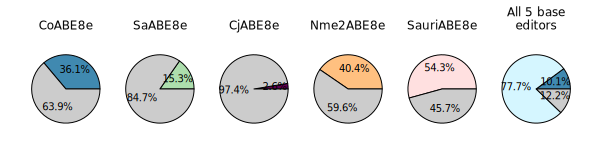

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(9.6, 2))
for n,ax in enumerate(axes):
    ABE = list(to_plot.keys())[n]
    to_plot[ABE].plot(kind='pie', ax=ax, fontsize=10, autopct='%1.1f%%', radius=0.8,
        colors = [colors[ABE], '#cccccc'] if ABE!='All 5 base\neditors' else ['#4089b0', '#d5f6ff', '#cccccc'],
        startangle = 0,  wedgeprops = {"edgecolor" : "black", 'linewidth': 1, 'antialiased': True}, labels=['']*len(to_plot[ABE]),
        textprops={'color':'k'}, counterclock=True)
    ax.set_title(BE_names[ABE] if ABE!='All 5 base\neditors' else ABE, size=12)
    ax.set_ylabel('')
    ax.set_aspect('equal')

plt.tight_layout()
plt.subplots_adjust(wspace=-0.5)
#plt.savefig('base_editor_targetable_pies.svg')
plt.show()

## Compute number of targetable sites in human genome

In [45]:
hg38 = {rec.id:rec for rec in SeqIO.parse('/shares/CIBIO-Storage/CM/scratch/users/matteo.ciciani/test_cosmid/hg38/hg38.fa',
                                          'fasta')}

In [46]:
hg38_main = ['chr{}'.format(i) for i in range(1,23)] + ['chrX', 'chrY']

In [47]:
PAM_nucleases = {'CoCas9': ['ATCT', 'ATGT', 'ATTT', 'GCCT', 'GCGT', 'GCTT', 'GAAT', 'GACT', 'GAGT', 'GATT', 'GTAT', 'GTCT', 'GTGT',
                            'GTTT'],
                 'SaCas9': ['GAAT', 'GAGT', 'GGAT', 'GGGT'],
                 'CjCas9': ['AACAC', 'AATAC', 'AGCAC', 'AGTAC', 'CACAC', 'CATAC', 'CGCAC', 'CGTAC', 'GACAC', 'GATAC', 'GGCAC',
                            'GGTAC'],
                 'Nme2Cas9': ['CC'],
                 'SpCas9': ['GG']}

In [48]:
PAM_nucleases_offset = {
    'CoCas9': 4,
    'SaCas9': 2,
    'CjCas9': 3,
    'Nme2Cas9': 4,
    'SpCas9': 2}

In [49]:
matches_per_chr_plus = {}
for Cas in PAM_nucleases:
    matches_per_chr_plus[Cas] = {}
    for chrom in hg38_main:
        matches_per_chr_plus[Cas][chrom] = {}
        for PAM in PAM_nucleases[Cas]:
            matches_per_chr_plus[Cas][chrom][PAM] = [m for m in re.finditer('(?={})'.format(PAM), str(hg38[chrom].seq).upper())]

In [50]:
matches_per_chr_minus = {}
for Cas in PAM_nucleases:
    matches_per_chr_minus[Cas] = {}
    for chrom in hg38_main:
        matches_per_chr_minus[Cas][chrom] = {}
        for PAM in PAM_nucleases[Cas]:
            PAM_revcomp = str(Seq.Seq(PAM).reverse_complement())
            matches_per_chr_minus[Cas][chrom][PAM] = [m for m in re.finditer('(?={})'.format(PAM_revcomp),
                                                                             str(hg38[chrom].seq).upper())]

In [51]:
matches_per_chr_overall = {}
for Cas in PAM_nucleases:
    matches_per_chr_overall[Cas] = {}
    for chrom in hg38_main:
        matches_per_chr_overall[Cas][chrom] = []
        for PAM in PAM_nucleases[Cas]:
            matches_per_chr_overall[Cas][chrom].extend([m.start()-3-PAM_nucleases_offset[Cas]
                                                        for m in matches_per_chr_plus[Cas][chrom][PAM]])
            matches_per_chr_overall[Cas][chrom].extend([m.start()+len(PAM)+3+PAM_nucleases_offset[Cas]
                                                        for m in matches_per_chr_plus[Cas][chrom][PAM]])

In [52]:
matches_per_chr_unique = {Cas:{chrom:np.unique(matches_per_chr_overall[Cas][chrom]) for chrom in matches_per_chr_overall[Cas]}
                          for Cas in matches_per_chr_overall}

In [53]:
genome_size = sum([len(str(hg38[chrom].seq).replace('N', '')) for chrom in hg38_main])

In [54]:
matches_per_chr_count = {Cas:{chrom:len(matches_per_chr_unique[Cas][chrom]) for chrom in matches_per_chr_overall[Cas]}
                          for Cas in matches_per_chr_overall}

In [55]:
total_number_sites = pd.DataFrame(matches_per_chr_count).sum()

In [56]:
genome_size = sum([len(str(hg38[chrom].seq).replace('N', '')) for chrom in hg38_main])

In [57]:
to_plot = pd.concat([total_number_sites, genome_size-total_number_sites], axis=1)
to_plot.columns = ['Targetable', 'Not targetable']

In [59]:
to_plot

,Targetable,Not targetable
CoCas9,347211656,2590429870
SaCas9,84521869,2853119657
CjCas9,49891730,2887749796
Nme2Cas9,292152924,2645488602
SpCas9,294195880,2643445646


In [60]:
colors_nuclease = {'CoCas9':'#4089b0', 'CjCas9':'#610051', 'Nme2Cas9':'#ffc080', 'SaCas9':'#addead', 'SpCas9':'#dddd00'}

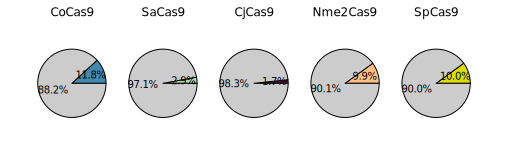

In [61]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(8, 2))
for n,ax in enumerate(axes):
    Cas9 = to_plot.index[n]
    to_plot.loc[Cas9].plot(kind='pie', ax=ax, fontsize=10, autopct='%1.1f%%',
        colors = [colors_nuclease[Cas9], '#cccccc'], radius=0.7,
        startangle = 0,  wedgeprops = {"edgecolor" : "black", 'linewidth': 1, 'antialiased': True}, labels=['', ''],
        textprops={'color':'k'}, counterclock=True)
    ax.set_title(Cas9, size=12)
    ax.set_ylabel('')
    ax.set_aspect('equal')

plt.tight_layout()
plt.subplots_adjust(wspace=-0.5)
plt.show()